### Importing Modules

In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque, namedtuple

import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

### Defining of environment

In [2]:
env = gym.make("Taxi-v3")
env_action_space = env.action_space.n
env_state = env.reset()
action = env.action_space.sample()
a, b, c, d = env.decode(env_state)
next_state, reward, done, info = env.step(action)
all_destinations = env.unwrapped.locs
print(f"Initial state : {env_state}")
print(f"Decoded information of initial state => x coordinate of taxi : {a}, y coordinate of taxi : {b}, Passenger location : {c}, Destination : {d}")
print(f"Dictionary : {0} = {all_destinations[0]}, {1} = {all_destinations[1]}, {2} = {all_destinations[2]}, {3} = {all_destinations[3]}, {4} = In taxi")

Initial state : 232
Decoded information of initial state => x coordinate of taxi : 2, y coordinate of taxi : 1, Passenger location : 3, Destination : 0
Dictionary : 0 = (0, 0), 1 = (0, 4), 2 = (4, 0), 3 = (4, 3), 4 = In taxi


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

### Defining of Epsilon greedy policy for the main Q values and for the option specific Q values

In [3]:
def epsilon_greedy(q_values, state, epsilon):
  if random.uniform(0, 1) >= epsilon:
    return np.argmax(q_values[state])
  else:
    return random.randint(0, 9)

def option_epsilon_greedy(q_values, state, epsilon):
    if random.uniform(0, 1) >= epsilon:
      state_x, state_y, _, _ = env.decode(state)
      return np.argmax(q_values[state_x][state_y][:6])
    else:
      return random.randint(0, 5)

### Defining of Intra-Option function

In [4]:
def IO(q_values_IO, update_frequency_IO, options_q_values, alpha = 0.1, epsilon = 0.01):
  gamma = 0.9                                                                    # Gamma is a Fixed parameter
  scores = []                                                                    # For storing Episodic rewards
  for _ in tqdm(range(10000)):                                                   # Ran for 10000 episodes
    state = env.reset()
    done = False
    ep_reward = 0
    while not done:
      action = epsilon_greedy(q_values_IO, state, epsilon)
      if action < 6:                                                             # Updation when primitive actions are chosen
        next_state, reward, done, _ = env.step(action)
        q_values_IO[state][action] += alpha * (reward + gamma * np.max(q_values_IO[next_state]) - q_values_IO[state][action])
        update_frequency_IO[state][action] += 1
        ep_reward += reward

        for i in range(6, 10):                                                   # Updating for options that will chose the primitive action in this state
          destination = env.unwrapped.locs[i - 6]
          q = options_q_values[i]
          opt_action = option_epsilon_greedy(q, state, epsilon)
          if opt_action == action:
            x_taxi, y_taxi, passenger_loc, dest = env.decode(state)
            if x_taxi == destination[0] and y_taxi == destination[1]:
              q_values_IO[state][i] += alpha * (reward + gamma * np.max(q_values_IO[next_state]) - q_values_IO[state][i])
            else:
              q_values_IO[state][i] += alpha * (reward + gamma * q_values_IO[next_state][i] - q_values_IO[state][i])
            update_frequency_IO[state][i] += 1
        state = next_state
      else:                                                                      # Updation when options where chosen
        if action == 6:                                                          # Option for making the taxi to move to Red location
          destination = env.unwrapped.locs[0]
          q = options_q_values[6]
        elif action == 7:                                                        # Option for making the taxi to move to Green location
          destination = env.unwrapped.locs[1]
          q = options_q_values[7]
        elif action == 8:                                                        # Option for making the taxi to move to Yellow location
          destination = env.unwrapped.locs[2]
          q = options_q_values[8]
        else:                                                                    # Option for making the taxi to move to Blue location
          destination = env.unwrapped.locs[3]
          q = options_q_values[9]
        rewards = []                                                             # Storing option specific rewards
        while True:
          opt_action = option_epsilon_greedy(q, state, epsilon)
          next_state, reward, done, _ = env.step(opt_action)
          state_x, state_y, _, _ = env.decode(state)
          next_state_x, next_state_y, _, _ = env.decode(next_state)
          rewards.append(reward)
                                                                                 # Updating the option specific q values
          q[state_x][state_y][opt_action] += alpha * (reward + gamma * np.max(q[next_state_x][next_state_y]) - q[state_x][state_y][opt_action])

          q_values_IO[state][opt_action] += alpha * (reward + gamma * np.max(q_values_IO[next_state]) - q_values_IO[state][opt_action])
          update_frequency_IO[state][opt_action] += 1
          x_taxi, y_taxi, passenger_loc, dest = env.decode(state)
          if x_taxi == destination[0] and y_taxi == destination[1]:              # Checking if the taxi has finished the execution of the option or not
                                                                                 # Updating Q values for the states
            q_values_IO[state][action] += alpha * (reward + gamma * np.max(q_values_IO[next_state]) - q_values_IO[state][action])
            update_frequency_IO[state][action] += 1
            break
          else:
                                                                                 # Updating Q values for the states
            q_values_IO[state][action] += alpha * (reward + gamma * q_values_IO[next_state][action] - q_values_IO[state][action])
            update_frequency_IO[state][action] += 1

          for i in range(6, 10):
            if i != action:
              destination_dash = env.unwrapped.locs[i - 6]
              q_dash = options_q_values[i]
              opt_action_dash = option_epsilon_greedy(q_dash, state, epsilon)
              if opt_action_dash == opt_action:
                if x_taxi == destination_dash[0] and y_taxi == destination_dash[1]:              # Checking if the taxi has finished the execution of the option or not
                                                                                 # Updating Q values for the states
                  q_values_IO[state][i] += alpha * (reward + gamma * np.max(q_values_IO[next_state]) - q_values_IO[state][i])
                else:
                                                                                 # Updating Q values for the states
                  q_values_IO[state][i] += alpha * (reward + gamma * q_values_IO[next_state][i] - q_values_IO[state][i])
                update_frequency_IO[state][i] += 1

          state = next_state
        R = 0
        for reward in rewards[::-1]:
          R = reward + gamma * R
        ep_reward += R
    scores.append(ep_reward)
  return scores

In [5]:
alpha_list = [0.01, 0.05, 0.1]
epsilon_list = [0.01, 0.1]
dic = {}
for alpha in alpha_list:
  for epsilon in epsilon_list:
    q_values_IO = np.zeros((500, 10))
    update_frequency_IO = np.zeros((500, 10))
    options_q_values = {6 : np.zeros((5, 5, 6)), 7 : np.zeros((5, 5, 6)), 8 : np.zeros((5, 5, 6)), 9 : np.zeros((5, 5, 6))}
    scores = IO(q_values_IO, update_frequency_IO, options_q_values, alpha, epsilon)
    dic[(alpha, epsilon)] = np.sum(scores)

100%|██████████| 10000/10000 [00:47<00:00, 212.07it/s]


In [6]:
print(dic)

{(0.01, 0.01): -764396.5937176169, (0.01, 0.1): -753138.4774177767, (0.05, 0.01): -114166.36302156514, (0.05, 0.1): -197433.7192513535, (0.1, 0.01): -28717.567596460936, (0.1, 0.1): -137793.86144545308}


In [7]:
opt_par = max(dic.keys(), key = lambda x : dic[x])
print(f"The best parameter is {opt_par}")

The best parameter is (0.1, 0.01)


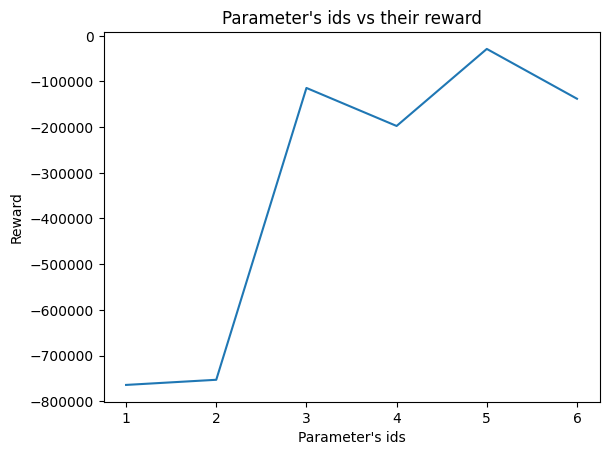

In [8]:
y = list(dic.values())
x =[]
for i in range(1, 7):
    x.append(i)
plt.plot(x, y)
plt.title("Parameter's ids vs their reward")
plt.xlabel("Parameter's ids")
plt.ylabel("Reward")
plt.show()